In [1]:
# Let's load values from the .env file
from dotenv import dotenv_values

config = dotenv_values()

# We also will need SQLAlchemy and its functions
from sqlalchemy import create_engine, types
from sqlalchemy.dialects.postgresql import JSON as postgres_json
from sqlalchemy import text # to be able to pass string

# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# this so called "line magic" command, amongst other things, stores the plots in the notebook document.
%matplotlib inline

# warnings supression
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# import the statsmodels.api module
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
# define variables for the login
pg_user = config['POSTGRES_USER']  # align the key label with your .env file !
pg_host = config['POSTGRES_HOST']
pg_port = config['POSTGRES_PORT']
pg_db = config['POSTGRES_DB']
pg_schema = config['POSTGRES_SCHEMA']
pg_pass = config['POSTGRES_PASS']

#SQL access details
url = f'postgresql://{pg_user}:{pg_pass}@{pg_host}:{pg_port}/{pg_db}'
engine = create_engine(url, echo=False)
engine.url # password is hidden
with engine.begin() as conn: 
    result = conn.execute(text(f'SET search_path TO {pg_schema};'))

Importing mart_song

In [3]:
with engine.begin() as conn: # Done with echo=False
    result = conn.execute(text(f'''
                               SELECT * FROM mart_song; 
                                '''))
    data = result.all()

### Let's create a dataframe out of that
df_song = pd.DataFrame(data) 

In [4]:
df_song

,year,semi_final,semi_draw_position,final_draw_position,country,artist_name,song_name,language,style,direct_qualifier_10,...,final_jury_votes,final_place,final_total_points,semi_place,semi_televote_points,semi_jury_points,semi_total_points,favourite_10,host_10,point_ratio
0,2023,1.0,1.0,20.0,Norway,Alessandra,Queen of Kings,English,Pop,0.0,...,11.0,5.0,268.0,6.0,102.0,NaN,102.0,0,0,0.149681
1,2023,1.0,2.0,NaN,Malta,The Busker,Dance (Our Own Party),English,Pop,NaN,...,NaN,NaN,NaN,15.0,3.0,NaN,3.0,0,0,0.090438
2,2023,1.0,3.0,5.0,Serbia,Luke Black,Samo mi se spava,"Serbian, English",Pop,0.0,...,6.0,24.0,30.0,10.0,37.0,NaN,37.0,0,0,0.122570
3,2023,1.0,4.0,NaN,Latvia,Sudden Lights,Aijā,English,Rock,NaN,...,NaN,NaN,NaN,11.0,34.0,NaN,34.0,0,0,0.061450
4,2023,1.0,5.0,2.0,Portugal,Mimicat,Ai Coração,Portuguese,Pop,0.0,...,9.0,23.0,59.0,9.0,74.0,NaN,74.0,0,0,0.107451
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
554,2009,NaN,NaN,3.0,France,Patricia Kaas,Et s'il fallait le faire,French,Ballad,1.0,...,NaN,8.0,218.0,NaN,NaN,NaN,NaN,0,0,0.170664
555,2009,NaN,NaN,10.0,Russia,Anastasiya Prikhodko,Mamo,"Russian, Ukrainian",Ballad,1.0,...,NaN,11.0,185.0,NaN,NaN,NaN,NaN,0,1,0.236264
556,2009,NaN,NaN,17.0,Germany,Alex Swings Oscar Sings!,Miss Kiss Kiss Bang,English,Pop,1.0,...,NaN,20.0,91.0,NaN,NaN,NaN,NaN,0,0,0.136855
557,2009,NaN,NaN,23.0,United Kingdom,Jade Ewen,It's My Time,English,Ballad,1.0,...,NaN,5.0,328.0,NaN,NaN,NaN,NaN,0,0,0.181626


In [11]:
df_song.columns

Index(['year', 'semi_final', 'semi_draw_position', 'final_draw_position',
       'country', 'artist_name', 'song_name', 'language', 'style',
       'direct_qualifier_10', 'gender', 'main_singers', 'key', 'loudness_db',
       'beats_per_min', 'energy', 'danceability', 'happiness', 'acousticness',
       'instrumentalness', 'liveness', 'speechiness', 'backing_dancers',
       'backing_singers', 'backing_instruments', 'instrument_10',
       'qualified_10', 'final_televote_points', 'final_jury_points',
       'final_televote_votes', 'final_jury_votes', 'final_place',
       'final_total_points', 'semi_place', 'semi_televote_points',
       'semi_jury_points', 'semi_total_points', 'favourite_10', 'host_10',
       'point_ratio'],
      dtype='object')

In [ ]:
# Checking the Direct Qualifier 10 column



In [24]:
df_song['final_place'] == 1.0

0      False
1      False
2      False
3      False
4      False
       ...  
554    False
555    False
556    False
557    False
558    False
Name: final_place, Length: 559, dtype: bool

In [25]:
df_song_filtered = df_song[['style','year','final_place']]
df_song_filtered


,style,year,final_place
0,Pop,2023,5.0
1,Pop,2023,NaN
2,Pop,2023,24.0
3,Rock,2023,NaN
4,Pop,2023,23.0
...,...,...,...
554,Ballad,2009,8.0
555,Ballad,2009,11.0
556,Pop,2009,20.0
557,Ballad,2009,5.0


In [26]:
df_song['style'].unique()

array(['Pop', 'Rock', 'Ballad', 'Traditional', 'Dance', 'Opera'],
      dtype=object)

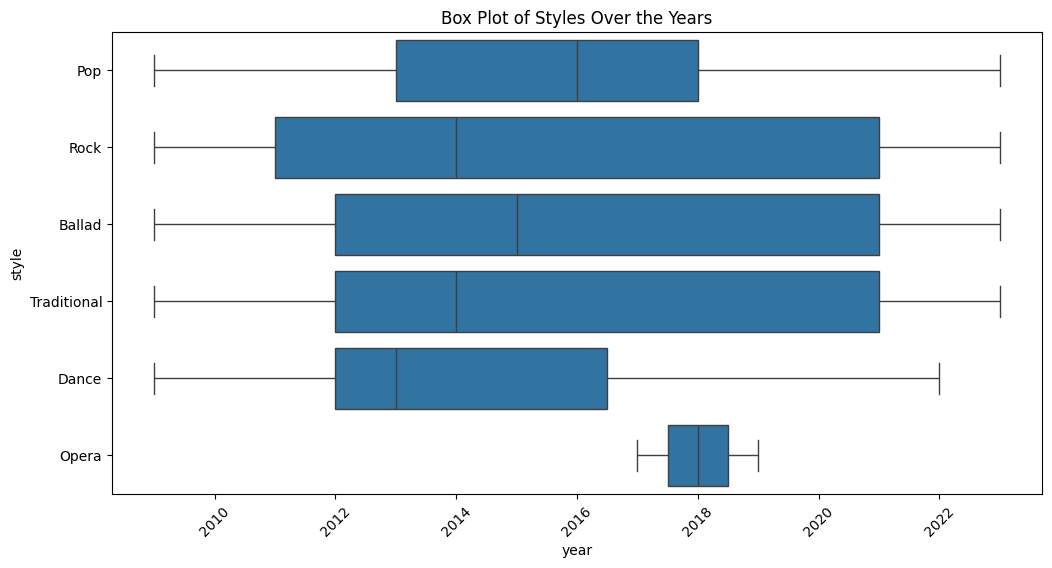

In [15]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_song_filtered, x="year", y="style")
plt.xticks(rotation=45)
plt.title("Box Plot of Styles Over the Years")
plt.show()

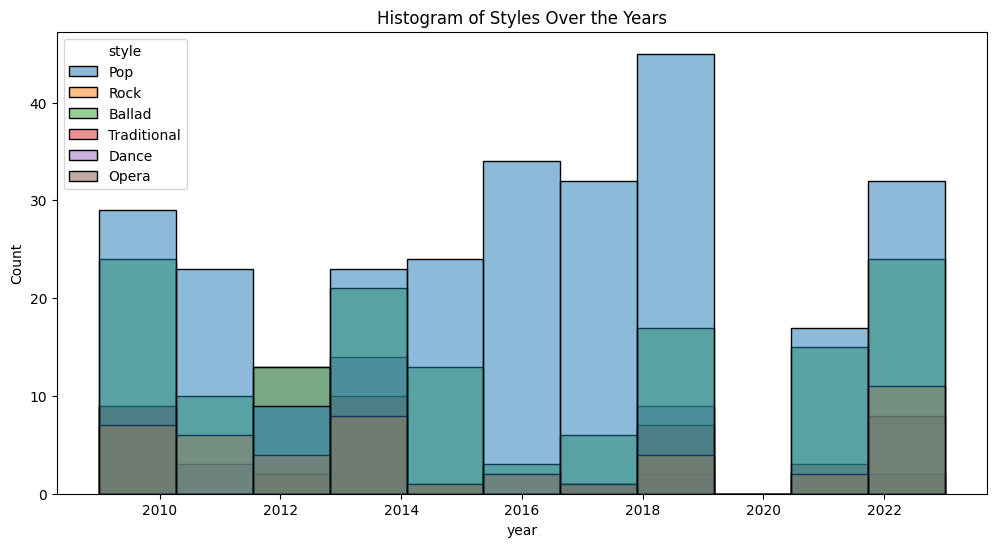

In [21]:
plt.figure(figsize=(12, 6))
sns.histplot(data=df_song_filtered,x = 'year', hue='style')
plt.title("Histogram of Styles Over the Years")
plt.show()

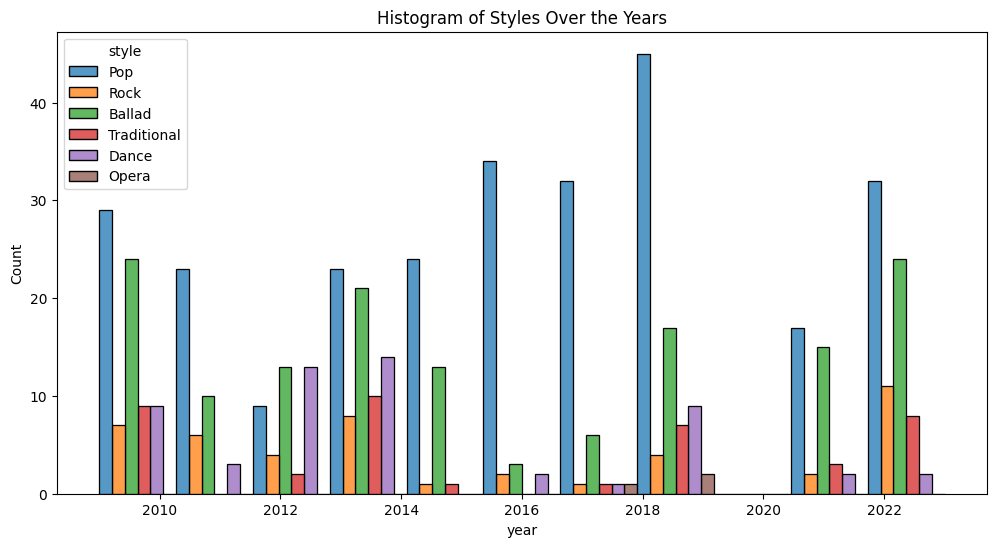

In [28]:
plt.figure(figsize=(12, 6))
sns.histplot(data=df_song_filtered,x = 'year', hue='style', multiple='dodge')
plt.title("Histogram of Styles Over the Years")
plt.show()

In [30]:
df_winner_songs = df_song_filtered[df_song_filtered['final_place'] == 1.0]
df_winner_songs

,style,year,final_place
10,Pop,2023,1.0
42,Traditional,2022,1.0
115,Rock,2021,1.0
148,Ballad,2019,1.0
163,Pop,2018,1.0
208,Ballad,2017,1.0
272,Pop,2016,1.0
312,Pop,2015,1.0
343,Ballad,2014,1.0
363,Pop,2013,1.0


In [38]:
df_semi_final_songs = df_song_filtered[df_song_filtered['final_place'] == 2.0]
df_semi_final_songs

,style,year,final_place
14,Pop,2023,2.0
75,Pop,2022,2.0
114,Ballad,2021,2.0
155,Pop,2019,2.0
175,Pop,2018,2.0
232,Pop,2017,2.0
268,Pop,2016,2.0
295,Pop,2015,2.0
335,Traditional,2014,2.0
378,Ballad,2013,2.0


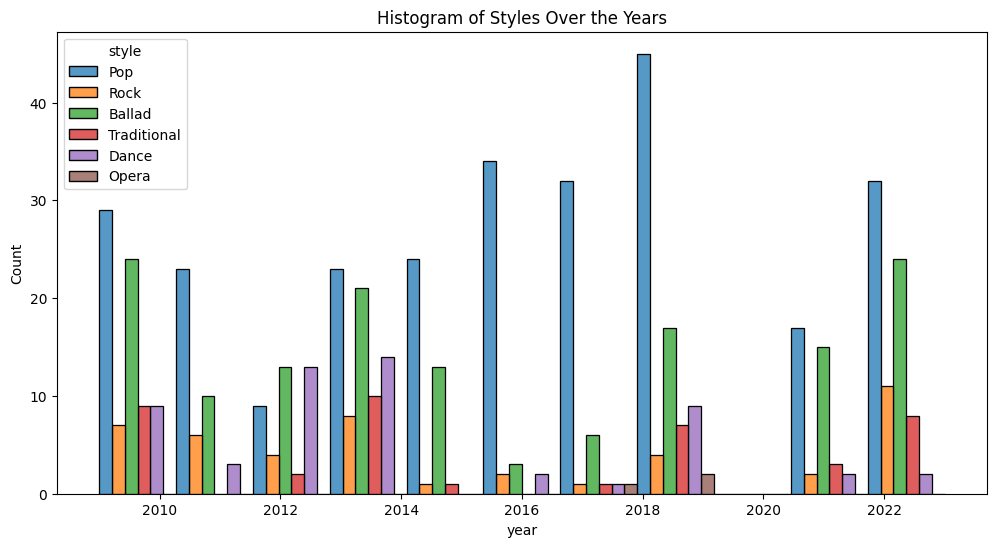

In [39]:
plt.figure(figsize=(12, 6))
sns.histplot(data=df_song_filtered,x = 'year', hue='style', multiple='dodge')
plt.title("Histogram of Styles Over the Years")
plt.show()

In [ ]:
sns.relplot(x='', y='', kind='scatter', 
            hue='', 
            col = '',
            row = '',
            data=);

<bound method Series.unique of 0      0
1      0
2      0
3      0
4      0
      ..
554    0
555    0
556    0
557    0
558    0
Name: favourite_10, Length: 559, dtype: int64>

In [44]:
df_song_filtered1 = df_song[['year','language', 'style',
       'direct_qualifier_10', 'gender', 'main_singers', 'key', 'loudness_db',
       'beats_per_min', 'energy', 'danceability', 'happiness', 'acousticness',
       'instrumentalness', 'liveness', 'speechiness', 'backing_dancers',
       'backing_singers', 'backing_instruments', 'instrument_10', 'final_place', 'semi_place',
       'point_ratio']]

In [50]:
year_filter = df_song_filtered1['year'].isin(range(2016, 2023))

In [51]:
df_song_filtered1[year_filter].corr(method='pearson', numeric_only=True)

,year,direct_qualifier_10,main_singers,beats_per_min,energy,danceability,happiness,acousticness,instrumentalness,liveness,speechiness,backing_dancers,backing_singers,backing_instruments,instrument_10,final_place,semi_place,point_ratio
year,1.000000,-0.011094,0.036392,-0.020848,-0.038674,0.159561,0.178667,0.060211,-0.108269,0.049738,0.127531,0.275062,-0.195845,0.087815,0.136348,-0.027109,-0.037907,0.017676
direct_qualifier_10,-0.011094,1.000000,-0.008681,0.068447,0.017133,0.083377,0.028581,0.109420,-0.118313,0.033182,0.011062,-0.163411,0.007305,0.028941,0.079241,0.207505,NaN,0.349575
main_singers,0.036392,-0.008681,1.000000,-0.057166,0.079914,0.008224,0.092396,-0.001140,0.091423,0.033321,0.010452,-0.102281,-0.083068,-0.028956,0.060486,0.011082,0.017833,-0.072963
beats_per_min,-0.020848,0.068447,-0.057166,1.000000,0.180535,0.084051,0.073311,-0.136269,-0.059196,-0.053599,0.043034,0.019906,-0.050121,-0.038508,0.010001,0.167279,0.070182,-0.021164
energy,-0.038674,0.017133,0.079914,0.180535,1.000000,0.314414,0.462380,-0.651962,-0.065980,0.034874,0.307676,0.187003,0.123169,0.171875,0.127790,0.063743,-0.044670,0.009222
danceability,0.159561,0.083377,0.008224,0.084051,0.314414,1.000000,0.553467,-0.270682,-0.115378,0.009220,0.277916,0.358906,0.067657,0.034300,0.060486,-0.043180,-0.073495,0.051604
happiness,0.178667,0.028581,0.092396,0.073311,0.462380,0.553467,1.000000,-0.298596,-0.205537,0.132474,0.311246,0.241559,0.047140,0.135601,0.170690,-0.051024,-0.120244,-0.015909
acousticness,0.060211,0.109420,-0.001140,-0.136269,-0.651962,-0.270682,-0.298596,1.000000,-0.062444,-0.066336,-0.099214,-0.189824,-0.130014,-0.159294,-0.068182,-0.137519,-0.058086,-0.022206
instrumentalness,-0.108269,-0.118313,0.091423,-0.059196,-0.065980,-0.115378,-0.205537,-0.062444,1.000000,-0.046532,-0.151987,-0.045409,0.194318,0.045071,0.003451,0.041416,0.075067,0.018615
liveness,0.049738,0.033182,0.033321,-0.053599,0.034874,0.009220,0.132474,-0.066336,-0.046532,1.000000,0.107367,0.053703,-0.112469,-0.081563,0.032370,-0.050183,0.173072,-0.157072


In [ ]:
ax =plt.subplots(figsize=(8,6))
sns.heatmap('pearson'.corr, xticklabels=pearsoncorr.columns, yticklabels=pearsoncorr.columns, cmap='Greens', annot=True)